### <center> WK3 CNN Pathological Image Classification
Github Https: https://github.com/wayne-ck19/CSCA_5642.git
#### 1 Introduction

#### 1.1 Data Volumne and Computational Power Challenge
This project has about 200,000 training images.Each raw image has 96 x 96 pixels with 3 chanels (RGB color). Each image takes about 110 k RAM. If we load all images into the Python, it will take about 21 Gb RAM. This is just the raw image size. If applying CNN or advanced ResNet models, the size of all processed images will be significantly bigger. Secondly, the processing of large volume of image matries requires GPU power. We will need to perform below two steps to prepare this mini project

* Use tensorflow generator to load images in batches as we train the model, instead of loading them into RAM in one load
* We will need to install Navidia CUDA and cuDNN libarary to enable Tensorflow GPU support. GPUs will be used to train this CNN and advanced ResNet model

#### 1.2 Work Plan
* Step 1: EDA. <br>  This Kaggle data set is fairly clean and no data cleaning is needed. Not much EDA work is need either. We can show some images and plot a bar chart on classification <br>

* Step 2: Model Architecture: We will run this week's case on a NVIDIA RTX 2000 Ada Generation Laptop GPU. The readily available large CNN models such as ResNet50 and VGG will be overloading this hardware. Our plan is to

  * (1) test this image classification project using a simple base model comprising two CNN layers with each layer having around 32 to 64 filters. This simple CNN may have around 1 million trainable parameters.
  * (2) use a deeper CNN architecture with Residual block. As deeper CNN will likely see gradient diminishing. We will use Residual network (ResNet). We will use about 3 resdiual blocks with each block having 128 to 512 convolution filters. This model will likely have about over 10 million trainable parameters. <br><br>

* Step 3: Apply both fine tuned simple CNN and ResNet models on Test Images. We feed test images to the model and make prediction and submit to Kaggle for scoring.
  

#### 2. Hardware Check and Enabling GPU Acceleration

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, resnet50
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### Test GPU device and initilize GPU acceleration on a test tensor 

In [3]:
with tf.device('/GPU:0'):
    print(tf.reduce_sum(tf.random.normal(shape = [500,500])))

tf.Tensor(73.26602, shape=(), dtype=float32)


In [4]:
tf.debugging.set_log_device_placement(True)
c = tf.reduce_sum(tf.random.normal(shape = [500,500]))
print(c)

tf.Tensor(-796.6753, shape=(), dtype=float32)


#### 3. Data Cleaning and EDA

##### 3.1 Take a file from train_label.csv and display the image

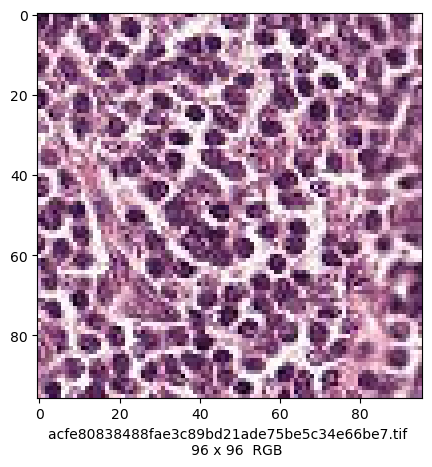

In [7]:
csv_path = '.\\path_images\\train_labels.csv'
image_folder = '.\\path_images\\train'
df = pd.read_csv(csv_path)
imj = 5
sample_path = os.path.join(image_folder, df.iloc[imj,0]+'.tif')
sample_image = Image.open(sample_path)
fig = plt.figure(figsize = (5,5))
plt.xlabel(f'{df.iloc[imj,0]}.tif \n   {sample_image.size[0]} x {sample_image.size[1]}  RGB')
plt.imshow(sample_image)

##### 3.2 Check if the Classes are Balanced

C:\Users\WaChen\AppData\Local\Temp\ipykernel_20692\3666094353.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_counts = pd.value_counts(df['label'])


Text(0, 0.5, 'Counts of Labels')

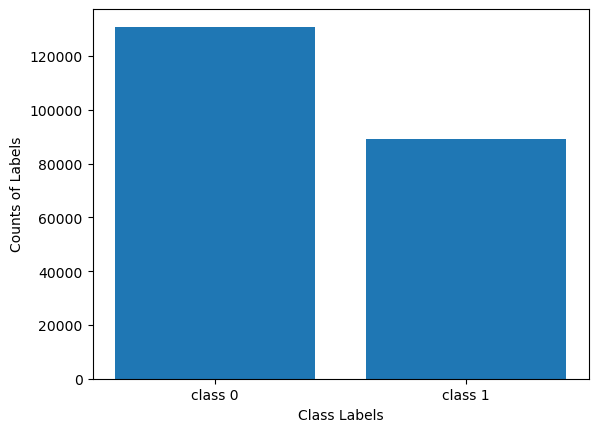

In [11]:
class_counts = pd.value_counts(df['label'])
class_counts.index = ['class 0', 'class 1']
plt.bar(class_counts.index, class_counts)
plt.xlabel('Class Labels')
plt.ylabel('Counts of Labels')

##### Findings
* The class 0 and class 1 have a ratio about 1.2 : 1. We will randomly drop some class 0 cases making the classes balanced

##### 3.3 Preprocessing
* Prepare a dataframe consisting of image full paths and associated labels. We will use tensorflow image generator. The generator requires a dataframe containing the information of file paths and labels.
* Normalize the images
* Get an image training and validation set generator to load images in batches as we train the model

##### <font color = 'blue'> 3.3.1 get_img_file_name: <br><br> This below function is to 
* get the dataframe consisting of image names in the training folder and associated labels extracted from the provided train_labels.csv file;
* randomly truncate excessive class 0, making a balanced label class set

In [19]:
def get_img_file_name(directory, csv_path, balanced = False):
    img_flist = [f for f in os.listdir(path = directory) if f.endswith('.tif')]
    img_name = [f.removesuffix('.tif') for f in img_flist]
    df_label_full = pd.read_csv(csv_path, names = ['id', 'Label'])
    mask = df_label_full['id'].isin(img_name)
    df_label = df_label_full[mask]
    df_label.insert(0, 'fname', img_flist) # we need full name including file extention for tf image generator to find images
    # also we need full path + file names for image generator to find images
    df_label.loc[:, ['fname']] = df_label['fname'].apply(lambda x:os.path.join(directory, x))
    
    df_label = df_label.drop('id', axis = 1)
    df_label['Label'] = df_label['Label'].astype(int) # the orignal labes are strings. converting to integer
    
    ## option to discard excessive rows from one class, making classes balanced
    if balanced:
        df_label_0 = df_label[df_label['Label'] == 0]
        n0_minus_n1 = df_label['Label'].value_counts()[0] - df_label['Label'].value_counts()[1] # number of label 0 minus label 1
        sample_0_to_drop = df_label_0.sample(n = int(0.9*n0_minus_n1)) # make 0 label slightly higher than 1
        index_of_0_todrop = sample_0_to_drop.index
        df_label.drop(index_of_0_todrop, axis = 0, inplace = True)
        
    ## shuffle the file names and lables. ImageDataGenerator does not shuffle data before splitting
    df_shuffle = df_label.sample(frac = 1, random_state = 30).reset_index(drop = True)
    ## ATTENTION: We shall use random_state to ensure we don't mix training and validation in fine tuning
    
    return df_shuffle


##### <font color = 'blue'> 3.3.2 Normalize images with mean and std 


The provided images are 96 x 96 x 3 in RGB color channels. We will normalize the images using standard normalization method to centralize each channel to the means of R, G and B colors. 

In [7]:
def custom_preprocess(image):
    mean = np.array([0.485, 0.456, 0.406])  # these means and stds are for RGB (referenced from pytorch manual)
    std = np.array([0.229, 0.224, 0.225])  # red, blue and green
    image = (image / 255.0 - mean) / std
    
    return image

##### <font color = 'blue'> 3.3.3 get_img_generator: <br><br> This is to establish a generator for training and validation image data sets

In [22]:
def get_img_generator(df, preprocess_fun, batchsize = 64, img_resize = 224, shuffle_train = True):
    
    datagen = ImageDataGenerator(preprocessing_function = preprocess_fun, validation_split = 0.3,
                                horizontal_flip = False, vertical_flip = False) 
    ## No image augmentation. I found augmentation didn't improve results at least for this project                              
    col = df.columns
    
    train_gen = datagen.flow_from_dataframe(dataframe = df, x_col = col[0], y_col = col[1],
                                            target_size = (img_resize, img_resize), batch_size = batchsize, class_mode = 'raw',
                                            subset = 'training',
                                            shuffle = shuffle_train)
    
    validation_gen = datagen.flow_from_dataframe(dataframe = df, x_col = col[0], y_col = col[1],
                                            target_size = (img_resize, img_resize), batch_size = batchsize, class_mode = 'raw',
                                            subset = 'validation',
                                            shuffle = False) # no shuffle for validation
    return train_gen, validation_gen



##### 3.4 Testing the Preprocessing Pipeline
* Function 1: undo_preprocess: This function is to rewind the preprocessed image in image generator. the purpose is to check if the preprocessed image can be rollbacked to the original image and to validate the preprocess <br><br>
* Function 2: display_sample: This function is to display the raw sample image and the corresponding preprocessed image. The purpose is to observe the consistency of the preprocessing 

In [9]:
def undo_preprocess(image_input, resnet_50 = False, back_to_rgb = False):

    mean = np.array([0.485, 0.456, 0.406])  # these means and stds are for RGB (referenced from pytorch manual)
    std = np.array([0.229, 0.224, 0.225])
    
    image = np.copy(image_input)
    if resnet_50: # resnet50 uses BGR
        image[:,:,0] += 103.939 # blue
        image[:,:,1] += 116.779 # green
        image[:,:,2] += 123.68 # red
    else:
        image = (image * std + mean) # get the range back to (0,1) for imshow()
        image = np.clip(image, 0, 1)
        
    if back_to_rgb:
        image = image[..., ::-1] # reverse from BGR back to RGB format Flip the last dimension
    
    return image

def display_sample(image_gen, count = 1, nst_in_batch = 0, resnet_50 = True):
    ct = 0
    all_file_names = image_gen.filenames # this is a fixed list, it doens't shuffle with data
    for batch in image_gen:        
        if ct >= count: 
            id_indexArray = (image_gen.batch_index - 1)*image_gen.batch_size + nst_in_batch
            print(id_indexArray)
            ind_filename = image_gen.index_array[id_indexArray]
            file_name = all_file_names[ind_filename]
            print(file_name)
            fetched_image = batch[0][nst_in_batch]
            break
        ct += 1

    raw_img = Image.open(file_name)
    fig = plt.figure()
    plt.xlabel('original image 96x96, RGB')
    plt.imshow(raw_img)

    #==========================
    proc_image = undo_preprocess(fetched_image, resnet_50 = resnet_50, back_to_rgb = False)
    fig2 = plt.figure()    
    plt.xlabel('Normalized image with RBG mean and std \n (unwind to (0,1) for imshow())')
    plt.imshow(proc_image)


##### <font color='blue'> 3.4.1 Preprocessing Pipeline Testing: Fetch an image from training folder, preprocess it and compare with the raw image

Found 36012 validated image filenames.
Found 9002 validated image filenames.
192
.\path_images\small_sample\3bbe5d39859555bac457ab7f6ec714c422a06f02.tif


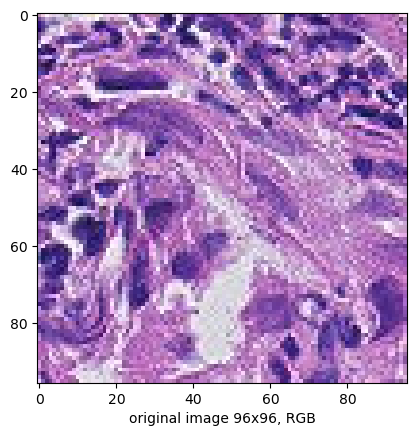

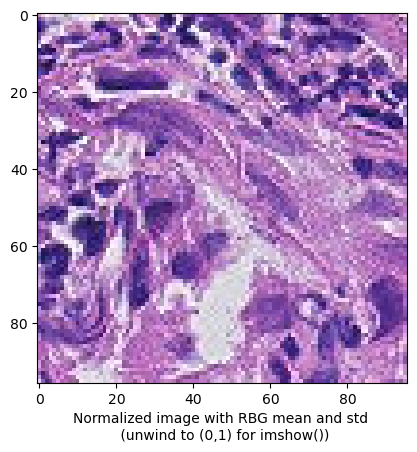

In [75]:
path_relative = os.path.join('.\\', 'path_images\\small_sample')
csv_path = '.\\path_images\\train_labels.csv'
df_img_sel = get_img_file_name(path_relative, csv_path) # get the dataframe of images in small_sample folder
df_img_sel.to_csv(os.path.join(path_relative, 'sel_labels.csv'), index = False)
ImageLoad_train, ImageLoad_val = get_img_generator(df_img_sel, custom_preprocess, img_resize = 96, shuffle_train=True)   
display_sample(ImageLoad_train, count=3, resnet_50 = False)

### <center> Model and Analysis
### <center> Part I: Base Model: a Simple CNN Model 
### 4. Simple CNN Model Architecture and Model Build
#### 4.1 Model Subclass

* We first try a simple shallow CNN model (deep CNN model with too many layers will have gradient diminishing issue.
* If adding more layers, we will need Residual block (see Part II)

In [16]:
class ShallowCNN(tf.keras.Model):
    def __init__(self, num_class, dropout_rate = 0.5):
        super(ShallowCNN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, 2, strides = 1, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.Activation('relu')
        self.pool1 = tf.keras.layers.MaxPooling2D(2, 2, padding = 'same')  # 96x96 -> 48x48
        self.conv2 = tf.keras.layers.Conv2D(32, 3, strides = 1, padding='same', activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.Activation('relu')
        self.pool2 = tf.keras.layers.MaxPooling2D(2, 2)  # 48x48 -> 24x24
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation = 'relu')
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(num_class, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        x = self.dense(x)
        return x

##### 4.2 Model Summary and Model Architecture Exhibition

In [17]:
### Create a model instance and Build the model to show the architecture details
# 1. instance
simpleCNN_exhibit = ShallowCNN(num_class = 1)
# 2. build with an input shape ( to show model.summary(), we have to build it first)
simpleCNN_exhibit.build(input_shape = (None, 96, 96, 3))
# 3. overall model summary
simpleCNN_exhibit.summary()

Model: "shallow_cnn_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           multiple                  208       
                                                                 
 batch_normalization_6 (Batc  multiple                 64        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   multiple                  0         
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           multiple                  4640      
                                                                 
 batch_normalization_7 (Batc  multiple               

### 5. Simple CNN Model Training 

#### 5.1 Initial Training with low dropout rate ( force the model to learn as many images, high probability of overfitting)

In [46]:
path_relative = os.path.join('.\\', 'path_images\\train')
csv_path = '.\\path_images\\train_labels.csv'
df_img_full = get_img_file_name(path_relative, csv_path, balanced = True) # get the dataframe of images in small_sample folder
print(df_img_full['Label'].value_counts())
ImageGen_train, ImageGen_val =  get_img_generator(df_img_full, preprocess_fun = custom_preprocess, batchsize = 32, img_resize = 96, shuffle_train=True)  

SimpleCNN_model = ShallowCNN(num_class = 1, dropout_rate = 0.1)
# compile first
SimpleCNN_model.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=1.0e-5), 
                     loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                     metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
# set up early stop and learning rate adapting
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 0.001)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 1.0e-7)
# train using data generator
#ImageGen_train.reset()
#ImageGen_val.reset()
hist01_cnn = SimpleCNN_model.fit(ImageGen_train, validation_data = ImageGen_val, epochs = 10, callbacks = [lr_schedule, early_stop])
pd.DataFrame(hist01_cnn.history).to_csv('.\\ResBalanceV2\\hist01_cnn.csv', index = False)
SimpleCNN_model.save_weights('.\\ResBalanceV2\\simpleCNN_stg00_weights.h5')

Label
0    93297
1    89117
Name: count, dtype: int64
Found 127690 validated image filenames.
Found 54724 validated image filenames.
Epoch 1/10
3991/3991 [==============================] - 504s 126ms/step - loss: 0.7162 - accuracy: 0.5019 - precision_11: 0.4896 - recall_11: 0.3834 - auc_11: 0.4982 - val_loss: 0.6939 - val_accuracy: 0.5072 - val_precision_11: 0.4840 - val_recall_11: 0.2480 - val_auc_11: 0.4955 - lr: 1.0000e-05
Epoch 2/10
3991/3991 [==============================] - 332s 83ms/step - loss: 0.6927 - accuracy: 0.5151 - precision_11: 0.5093 - recall_11: 0.2934 - auc_11: 0.5179 - val_loss: 0.6942 - val_accuracy: 0.5092 - val_precision_11: 0.4823 - val_recall_11: 0.1684 - val_auc_11: 0.4971 - lr: 1.0000e-05
Epoch 3/10
3991/3991 [==============================] - 330s 83ms/step - loss: 0.6912 - accuracy: 0.5219 - precision_11: 0.5191 - recall_11: 0.3344 - auc_11: 0.5315 - val_loss: 0.6947 - val_accuracy: 0.5033 - val_precision_11: 0.4765 - val_recall_11: 0.2479 - val_auc_11: 0.

#### 5.2 Fine Tuning with higher drop out and smaller initial learning rate

In [47]:
baseCNN_model_FT = ShallowCNN(num_class = 1, dropout_rate = 0.5)
baseCNN_model_FT.build(input_shape = (None, 96, 96, 3))
baseCNN_model_FT.load_weights('.\\ResBalanceV2\\simpleCNN_stg00_weights.h5')
baseCNN_model_FT.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=1.0e-6), 
                     loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                     metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
# set up early stop and learning rate adapting
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 0.001)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 1.0e-8)
# train using data generator
#ImageGen_train.reset()
#ImageGen_val.reset()
hist_baseCNN_FT = baseCNN_model_FT.fit(ImageGen_train, validation_data = ImageGen_val, epochs = 10, callbacks = [lr_schedule, early_stop])
pd.DataFrame(hist_baseCNN_FT.history).to_csv('.\\ResBalanceV2\\hist02_cnn.csv', index = False)
baseCNN_model_FT.save_weights('.\\ResBalanceV2\\simpleCNN_stg01_weights.h5')

Epoch 1/10
3991/3991 [==============================] - 334s 83ms/step - loss: 0.6897 - accuracy: 0.5262 - precision_12: 0.5238 - recall_12: 0.3654 - auc_12: 0.5402 - val_loss: 0.6944 - val_accuracy: 0.5055 - val_precision_12: 0.4840 - val_recall_12: 0.3039 - val_auc_12: 0.5002 - lr: 1.0000e-06
Epoch 2/10
3991/3991 [==============================] - 326s 82ms/step - loss: 0.6895 - accuracy: 0.5292 - precision_12: 0.5299 - recall_12: 0.3503 - auc_12: 0.5434 - val_loss: 0.6942 - val_accuracy: 0.5054 - val_precision_12: 0.4833 - val_recall_12: 0.2903 - val_auc_12: 0.4997 - lr: 1.0000e-06
Epoch 3/10
3991/3991 [==============================] - 327s 82ms/step - loss: 0.6890 - accuracy: 0.5308 - precision_12: 0.5332 - recall_12: 0.3427 - auc_12: 0.5462 - val_loss: 0.6943 - val_accuracy: 0.5055 - val_precision_12: 0.4844 - val_recall_12: 0.3102 - val_auc_12: 0.5004 - lr: 1.0000e-06
Epoch 4/10
3991/3991 [==============================] - 333s 83ms/step - loss: 0.6889 - accuracy: 0.5301 - preci

##### 5.3 Fine Tuning (with less drop out as the previous result showsi t underfits)

In [48]:
baseCNN_model_FT2 = ShallowCNN(num_class = 1, dropout_rate = 0.1)
baseCNN_model_FT2.build(input_shape = (None, 96, 96, 3))
baseCNN_model_FT2.load_weights('.\\ResBalanceV2\\simpleCNN_stg01_weights.h5')
baseCNN_model_FT2.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=1.0e-6), 
                     loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                     metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
# set up early stop and learning rate adapting
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6, min_delta = 0.001)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 1.0e-8)
# train using data generator
#ImageGen_train.reset()
#ImageGen_val.reset()
hist_baseCNN_FT2 = baseCNN_model_FT2.fit(ImageGen_train, validation_data = ImageGen_val, epochs = 10, callbacks = [lr_schedule, early_stop])
pd.DataFrame(hist_baseCNN_FT2.history).to_csv('.\\ResBalanceV2\\hist03_cnn.csv', index = False)
baseCNN_model_FT2.save_weights('.\\ResBalanceV2\\simpleCNN_stg02_weights.h5')

Epoch 1/10
3991/3991 [==============================] - 331s 83ms/step - loss: 0.6873 - accuracy: 0.5444 - precision_13: 0.5541 - recall_13: 0.3606 - auc_13: 0.5654 - val_loss: 0.6947 - val_accuracy: 0.5052 - val_precision_13: 0.4840 - val_recall_13: 0.3112 - val_auc_13: 0.5000 - lr: 1.0000e-06
Epoch 2/10
3991/3991 [==============================] - 327s 82ms/step - loss: 0.6869 - accuracy: 0.5441 - precision_13: 0.5517 - recall_13: 0.3724 - auc_13: 0.5650 - val_loss: 0.6948 - val_accuracy: 0.5036 - val_precision_13: 0.4833 - val_recall_13: 0.3458 - val_auc_13: 0.5007 - lr: 1.0000e-06
Epoch 3/10
3991/3991 [==============================] - 324s 81ms/step - loss: 0.6865 - accuracy: 0.5468 - precision_13: 0.5532 - recall_13: 0.3913 - auc_13: 0.5677 - val_loss: 0.6949 - val_accuracy: 0.5048 - val_precision_13: 0.4839 - val_recall_13: 0.3232 - val_auc_13: 0.5007 - lr: 1.0000e-06
Epoch 4/10
3991/3991 [==============================] - 337s 84ms/step - loss: 0.6861 - accuracy: 0.5480 - preci

#### 5.4 Training and Validation History

In [6]:
hist1 = pd.read_csv('.\\ResBalanceV2\\hist01_cnn.csv')
hist2 = pd.read_csv('.\\ResBalanceV2\\hist02_cnn.csv')
hist3 = pd.read_csv('.\\ResBalanceV2\\hist03_cnn.csv')

column_name = ['loss', 'accuracy', 'precision', 'recall', 'AUC Score Training', 'val_loss',
       'val_accuracy', 'val_precision', 'val_recall', 'AUC Score Validation', 'lr']
hist1.columns = column_name
hist2.columns = column_name
hist3.columns = column_name
df_hist = pd.concat([hist1, hist2, hist3], axis = 0)



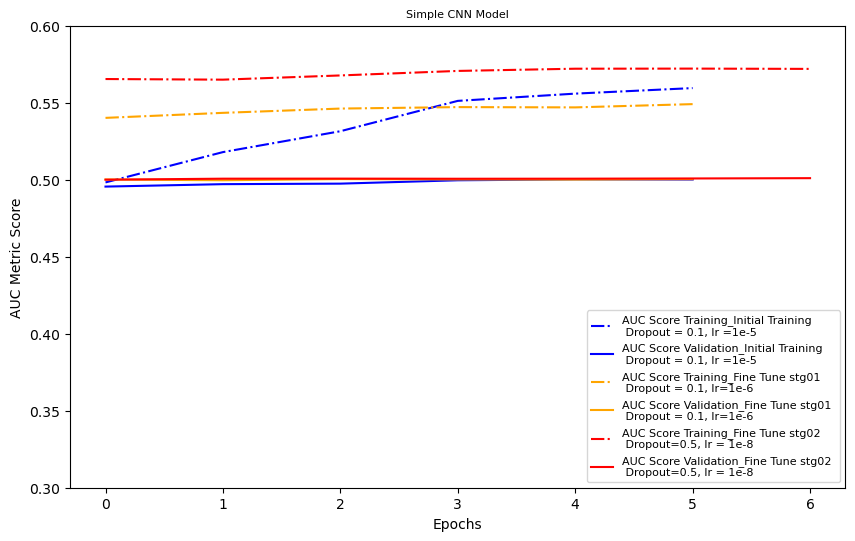

In [9]:
def hist_plot(df, columns, labels, color):
    n = len(df)
    x = np.linspace(0, n-1, n)
    styles = ['-.', '-']
    ax = plt.gca()
    for i in range(len(columns)):
        ax.plot(x, df[columns[i]], color = color, linestyle = styles[i], label = labels[i])

fig1 = plt.figure(figsize = (10,6))
histAll = [hist1, hist2, hist3]
texts = ['Initial Training \n Dropout = 0.1, lr =1e-5', 'Fine Tune stg01 \n Dropout = 0.1, lr=1e-6', 'Fine Tune stg02 \n Dropout=0.5, lr = 1e-8']
colors = ['blue', 'orange', 'red']
for i, hist_i in enumerate(histAll):
    columns = ['AUC Score Training', 'AUC Score Validation']
    
    labels = [columns[0] + '_' + texts[i], columns[1] + '_' + texts[i]]
    hist_plot(hist_i, columns, labels, colors[i])
#===================
plt.legend(fontsize = 8, loc = 'lower right')
plt.ylim(0.3, 0.6)
plt.xlabel('Epochs')
plt.ylabel('AUC Metric Score')
plt.title('Simple CNN Model', fontsize = 8)
plt.show()

##### Findings
* <font color='blue' size=3 > The simple CNN model is not sufficient to capture the critical features that are relavant to the desease cells in the pathological images. </font>
* <font color = 'blue' size=3> The results on validation data show that the model is not better than a random guess. </font>
* <font color = 'blue' size=3> The simple CNN model has around 2 million parameters, so it doens't have overfitting issue. It slightly overfits, but the overfitting is not that excessive </font>

#### 5.5 Model on Test Images

In [49]:
baseCNN_model_test = ShallowCNN(num_class = 1)
baseCNN_model_test.build(input_shape = (None, 96, 96, 3))
baseCNN_model_test.load_weights('.\\ResBalanceV2\\simpleCNN_stg02_weights.h5')

#=====================================
path_test = os.path.join('.\\', 'path_images\\test')
df_test = get_test_image(path_test)
img_test_gen = generator_test_image(df_test, custom_preprocess)
#======================================

ypred_prob = baseCNN_model_test.predict(img_test_gen)
ypred = (ypred_prob > 0.5).astype(int)

df_test['label'] = ypred
df_test_final = df_test.drop('fname_path', axis = 1)
df_test_final.columns = ['id', 'label']
df_test_final.to_csv('test_result_CNN.csv')

Found 57458 validated image filenames.
1796/1796 [==============================] - 98s 55ms/step


In [50]:
df_test_final.to_csv('test_result_CNN.csv', index=False)

### <center> Model and Analysis
### <center> Part II: Advanced CNN Model: Custom Built ResNet with Residual Block 
### 6.Simple ResNet Model Architecture and Model Build
#### 6.1 Model Subclass

In [20]:
class ResBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, stride = 1):
        super(ResBlock, self).__init__()
        self.conv_stride = stride
        self.conv1 = tf.keras.layers.Conv2D(num_filters, 3, strides = stride, padding = 'same', use_bias = False)
        self.BN1 = tf.keras.layers.BatchNormalization(axis = -1) # normalize over mini batches, but for each channel on the last axis
        self.conv2 = tf.keras.layers.Conv2D(num_filters, 3, strides = 1, padding = 'same', use_bias = False)
        self.BN2 = tf.keras.layers.BatchNormalization(axis = -1) 
        self.shortcut = tf.keras.layers.Conv2D(num_filters, 1, strides = stride, padding = 'same', use_bias = False)
        self.shortcut_BN = tf.keras.layers.BatchNormalization(axis = -1)

    def call(self, inputs, training = False):
        x = self.conv1(inputs)
        x = self.BN1(x, training = training)
        x = tf.keras.layers.Activation('relu')(x)
        x = self.conv2(x)
        x = self.BN2(x, training = training)
        input_resid = inputs
        if self.conv_stride > 1:
            input_resid = self.shortcut(input_resid)
            input_resid = self.shortcut_BN(input_resid, training = training)
            
        yres = tf.keras.layers.add([x, input_resid])
        yres = tf.keras.layers.Activation('relu')(yres)

        return yres
        
    
class BaselineCNN(tf.keras.Model):
    def __init__(self, num_class, dropout_rate = 0.5):
        super(BaselineCNN, self).__init__()
        # initial CNN layers
        self.conv1 = tf.keras.layers.Conv2D(64, 4, strides = 1, padding = 'same', use_bias = False) #  96x96x64
        self.bn1 = tf.keras.layers.BatchNormalization(axis = -1)
        self.activate = tf.keras.layers.Activation('relu')
        self.maxpool = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same') # 48x48x64
        # Residual blocks 
        self.stage1 = ResBlock(64, stride = 1) #ResBlock(32, stride = 1) # 48x48x64
        self.stage2 = [ResBlock(128, stride = 2), ResBlock(128, stride = 1)] # 24x24x64
        self.stage3 = [ResBlock(256, stride = 2), ResBlock(256, stride = 1)] # 12 x 12 x 128
        self.stage4 = [ResBlock(512, stride = 2), ResBlock(512, stride = 1)] # 6 x 6 x 256
        # CNN head layers
        self.pooling = tf.keras.layers.GlobalAveragePooling2D() # flatten the array
        self.dense1 = tf.keras.layers.Dense(512, activation = 'relu') #, kernel_regularizer = tf.keras.regularizers.l2(0.01))
        self.dropout = tf.keras.layers.Dropout(rate = dropout_rate)
        self.dense2 = tf.keras.layers.Dense(num_class, activation = 'sigmoid')

    def call(self, inputs, training = False):

        x = self.conv1(inputs)
        x = self.bn1(x, training = training)
        x = self.activate(x)
        x = self.maxpool(x)
     #   for block in self.stage1:
        x = self.stage1(x, training = training)
        for block in self.stage2:
            x = block(x, training = training)
        for block in self.stage3:
            x = block(x, training = training)
        for block in self.stage4:
            x = block(x, training = training)
        x = self.pooling(x)
        x = self.dense1(x)
        x = self.dropout(x, training = training)
        res = self.dense2(x)
        
        return res

##### 6.2 Model Summary and Model Architecture Exhibition

In [21]:
### Create a model instance and Build the model to show the architecture details
# 1. instance
baseline_exhibit = BaselineCNN(num_class = 1)
# 2. build with an input shape ( to show model.summary(), we have to build it first)
baseline_exhibit.build(input_shape = (None, 96, 96, 3))
# 3. overall model summary
baseline_exhibit.summary()

Model: "baseline_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          multiple                  3072      
                                                                 
 batch_normalization_10 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  multiple                  0         
                                                                 
 max_pooling2d_10 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 res_block (ResBlock)        multiple                  74240     
                                                                 
 res_block_1 (ResBlock)      multiple                 

### 6. Baseline ResNet Model Training 

#### 6.1 Initial Training with low dropout rate ( force the model to learn as many images)

In [25]:
path_relative = os.path.join('.\\', 'path_images\\train')
csv_path = '.\\path_images\\train_labels.csv'
df_img_full = get_img_file_name(path_relative, csv_path, balanced = True) # get the dataframe of images in small_sample folder
print(df_img_full['Label'].value_counts())
ImageGen_train, ImageGen_val =  get_img_generator(df_img_full, preprocess_fun = custom_preprocess, batchsize = 32, img_resize = 96, shuffle_train=True)  

resnet_model_v05 = BaselineCNN(num_class = 1, dropout_rate = 0.1)
# compile first
resnet_model_v05.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=1.0e-5), 
                     loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                     metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
# set up early stop and learning rate adapting
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 0.001)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 1.0e-7)
# train using data generator
#ImageGen_train.reset()
#ImageGen_val.reset()
hist_resnet_v05 = resnet_model_v05.fit(ImageGen_train, validation_data = ImageGen_val, epochs = 10, callbacks = [lr_schedule, early_stop])
pd.DataFrame(hist_resnet_v05.history).to_csv('.\\ResBalanceV2\\histRESNET_Baseline_v05.csv', index = False)
resnet_model_v05.save_weights('.\\ResBalanceV2\\baselineCNN_v05_weights.h5')

Label
0    93297
1    89117
Name: count, dtype: int64
Found 127690 validated image filenames.
Found 54724 validated image filenames.
Epoch 1/10
3991/3991 [==============================] - 1448s 362ms/step - loss: 0.7067 - accuracy: 0.4977 - precision_1: 0.4832 - recall_1: 0.4263 - auc_1: 0.4974 - val_loss: 0.6960 - val_accuracy: 0.5053 - val_precision_1: 0.4916 - val_recall_1: 0.2744 - val_auc_1: 0.4992 - lr: 1.0000e-05
Epoch 2/10
3991/3991 [==============================] - 346s 87ms/step - loss: 0.6928 - accuracy: 0.5302 - precision_1: 0.5211 - recall_1: 0.4561 - auc_1: 0.5406 - val_loss: 0.6968 - val_accuracy: 0.5021 - val_precision_1: 0.4916 - val_recall_1: 0.4686 - val_auc_1: 0.5009 - lr: 1.0000e-05
Epoch 3/10
3991/3991 [==============================] - 346s 87ms/step - loss: 0.6797 - accuracy: 0.5630 - precision_1: 0.5591 - recall_1: 0.4934 - auc_1: 0.5902 - val_loss: 0.7158 - val_accuracy: 0.5082 - val_precision_1: 0.4911 - val_recall_1: 0.0929 - val_auc_1: 0.5020 - lr: 1.0000

##### Findings
*<font color = 'blue'> <font size=3> The model has not been able to lean all major features of the images as evidenced by below 0.5 recall and precision. We will perform fine tune using the above trained model weights

#### 6.2 Fine Tune Stage 01 
* (1) Load saved weights from initial training; 
* (2) change learning rate and compile the model; 
* (3) run model.fit()

In [29]:
resnet_model_FT = BaselineCNN(num_class = 1, dropout_rate = 0.3)
resnet_model_FT.build(input_shape = (None, 96, 96, 3))
resnet_model_FT.load_weights('.\\ResBalanceV2\\baselineCNN_v05_weights.h5')
resnet_model_FT.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=1.0e-5), 
                     loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                     metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
# set up early stop and learning rate adapting
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 0.001)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 1.0e-8)
# train using data generator
ImageGen_train.reset()
ImageGen_val.reset()
hist_resnet_FT = resnet_model_FT.fit(ImageGen_train, validation_data = ImageGen_val, epochs = 10, callbacks = [lr_schedule, early_stop])
pd.DataFrame(hist_resnet_FT.history).to_csv('.\\ResBalanceV2\\histRESNET_Baseline_v05FT.csv', index = False)
resnet_model_FT.save_weights('.\\ResBalanceV2\\baselineCNN_v05FT_weights.h5')

Epoch 1/10
3991/3991 [==============================] - 332s 82ms/step - loss: 0.6542 - accuracy: 0.6086 - precision_5: 0.6046 - recall_5: 0.5719 - auc_5: 0.6536 - val_loss: 0.7264 - val_accuracy: 0.4976 - val_precision_5: 0.4900 - val_recall_5: 0.6119 - val_auc_5: 0.4987 - lr: 1.0000e-05
Epoch 2/10
3991/3991 [==============================] - 328s 82ms/step - loss: 0.6089 - accuracy: 0.6654 - precision_5: 0.6648 - recall_5: 0.6339 - auc_5: 0.7297 - val_loss: 0.8081 - val_accuracy: 0.5077 - val_precision_5: 0.4940 - val_recall_5: 0.1851 - val_auc_5: 0.5017 - lr: 1.0000e-05
Epoch 3/10
3991/3991 [==============================] - 334s 84ms/step - loss: 0.5514 - accuracy: 0.7157 - precision_5: 0.7148 - recall_5: 0.6944 - auc_5: 0.7936 - val_loss: 0.8177 - val_accuracy: 0.5023 - val_precision_5: 0.4901 - val_recall_5: 0.3829 - val_auc_5: 0.4990 - lr: 1.0000e-05
Epoch 4/10
3991/3991 [==============================] - 333s 84ms/step - loss: 0.4814 - accuracy: 0.7748 - precision_5: 0.7771 - r

##### Findings
* <font color='blue' size=3 > The model overfits after the  fine tuning stage with drop out rate of 0.1.</font>
* <font color = 'blue' size=3> We will increase drop out rate and fine tune again based on the weights from the above stge 1 fine tuning </font>

#### 6.3 Fine Tune Stage 2  
* The previous model overfits. We will increase drop out rate and decrease learning rate to fine tune the model based on previously trained weights

In [34]:
resnet_model_FT2 = BaselineCNN(num_class = 1, dropout_rate = 0.8)
resnet_model_FT2.build(input_shape = (None, 96, 96, 3))
resnet_model_FT2.load_weights('.\\ResBalanceV2\\baselineCNN_v05FT_weights.h5')
#===================================================================================
# path_relative = os.path.join('.\\', 'path_images\\train')
# csv_path = '.\\path_images\\train_labels.csv'
# df_img_full = get_img_file_name(path_relative, csv_path, balanced = True) # get the dataframe of images in small_sample folder
# print(df_img_full['Label'].value_counts())
# ImageGen_train, ImageGen_val =  get_img_generator(df_img_full, preprocess_fun = custom_preprocess, batchsize = 32, img_resize = 96, shuffle_train=True)  

#===================================================================================
resnet_model_FT2.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=1.0e-6), 
                     loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                     metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
# set up early stop and learning rate adapting
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 8, min_delta = 0.001)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 1.0e-8)
# train using data generator
ImageGen_train.reset()
ImageGen_val.reset()
hist_resnet_FT2 = resnet_model_FT2.fit(ImageGen_train, validation_data = ImageGen_val, epochs = 10, callbacks = [lr_schedule, early_stop])
pd.DataFrame(hist_resnet_FT2.history).to_csv('.\\ResBalanceV2\\hist_resnet_FT2.csv', index = False)
resnet_model_FT2.save_weights('.\\ResBalanceV2\\baselineCNN_FT2_weights.h5')

Epoch 1/10
3991/3991 [==============================] - 354s 88ms/step - loss: 0.4989 - accuracy: 0.7515 - precision_10: 0.7492 - recall_10: 0.7377 - auc_10: 0.8350 - val_loss: 0.8548 - val_accuracy: 0.4988 - val_precision_10: 0.4884 - val_recall_10: 0.4774 - val_auc_10: 0.4989 - lr: 1.0000e-06
Epoch 2/10
3991/3991 [==============================] - 348s 87ms/step - loss: 0.4873 - accuracy: 0.7596 - precision_10: 0.7579 - recall_10: 0.7452 - auc_10: 0.8446 - val_loss: 0.8610 - val_accuracy: 0.4980 - val_precision_10: 0.4878 - val_recall_10: 0.4862 - val_auc_10: 0.4987 - lr: 1.0000e-06
Epoch 3/10
3991/3991 [==============================] - 352s 88ms/step - loss: 0.4755 - accuracy: 0.7689 - precision_10: 0.7669 - recall_10: 0.7562 - auc_10: 0.8546 - val_loss: 0.8832 - val_accuracy: 0.4957 - val_precision_10: 0.4883 - val_recall_10: 0.6045 - val_auc_10: 0.4985 - lr: 1.0000e-06
Epoch 4/10
3991/3991 [==============================] - 354s 89ms/step - loss: 0.4664 - accuracy: 0.7758 - preci

#### 6.4 Training and Validation Metrics Visualization

##### Load previously saved training history

In [36]:
hist1 = pd.read_csv('.\\ResBalanceV2\\histRESNET_Baseline_v05.csv')

In [37]:
hist2 = pd.read_csv('.\\ResBalanceV2\\histRESNET_Baseline_v05FT.csv')

In [35]:
hist3 = pd.read_csv('.\\ResBalanceV2\\hist_resnet_FT2.csv')

In [38]:
hist1.columns

Index(['loss', 'accuracy', 'precision_1', 'recall_1', 'auc_1', 'val_loss',
       'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_auc_1', 'lr'],
      dtype='object')

In [39]:
column_name = ['loss', 'accuracy', 'precision', 'recall', 'AUC Score Training', 'val_loss',
       'val_accuracy', 'val_precision', 'val_recall', 'AUC Score Validation', 'lr']
hist1.columns = column_name
hist2.columns = column_name
hist3.columns = column_name
df_hist = pd.concat([hist1, hist2, hist3], axis = 0)

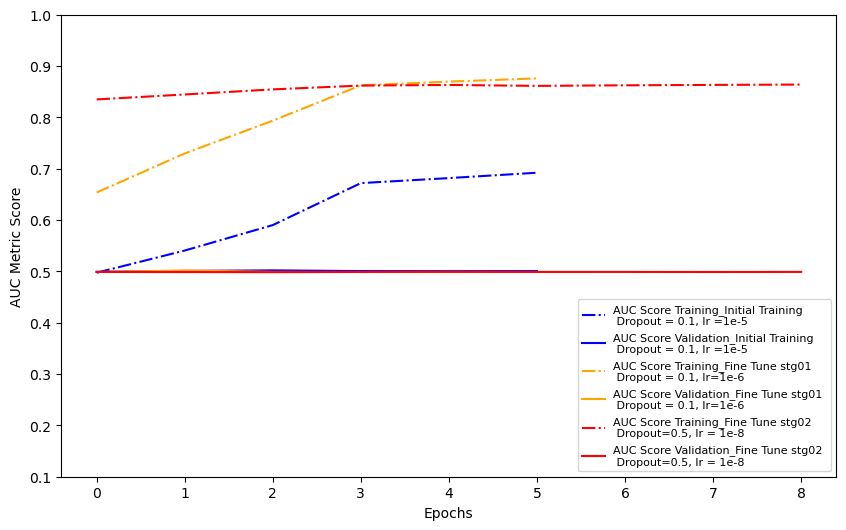

In [41]:
def hist_plot(df, columns, labels, color):
    n = len(df)
    x = np.linspace(0, n-1, n)
    styles = ['-.', '-']
    ax = plt.gca()
    for i in range(len(columns)):
        ax.plot(x, df[columns[i]], color = color, linestyle = styles[i], label = labels[i])

fig1 = plt.figure(figsize = (10,6))
histAll = [hist1, hist2, hist3]
texts = ['Initial Training \n Dropout = 0.1, lr =1e-5', 'Fine Tune stg01 \n Dropout = 0.1, lr=1e-6', 'Fine Tune stg02 \n Dropout=0.5, lr = 1e-8']
colors = ['blue', 'orange', 'red']
for i, hist_i in enumerate(histAll):
    columns = ['AUC Score Training', 'AUC Score Validation']
    
    labels = [columns[0] + '_' + texts[i], columns[1] + '_' + texts[i]]
    hist_plot(hist_i, columns, labels, colors[i])
#===================
plt.legend(fontsize = 8, loc = 'lower right')
plt.ylim(0.1, 1.0)
plt.xlabel('Epochs')
plt.ylabel('AUC Metric Score')
plt.show()

##### Findings
* <font color='blue' size=3 > It has shown the model overfits, despite the use of high drop out rate and small learning rate. </font>
* <font color = 'blue' size=3> It indicates the ResNet model that has more than 10 million parameters still can not effectively focus on important features that are critical to desease cell detection. </font>
* <font color = 'blue' size=3> The 10 million-parameter ResNet model has similar performance as the previous simple CNN on validation data. </font>
* <font color = 'blue' size=3> The validation results show that the model is not better than random guess. However, we have tried everything we could in this 1 week short period without much guidance. We will have to stop here, and will come back in week 6 trying to find a better architecture that can solve this problem. Probably we will try either a pretrained model, or try to use attention layer allowing the model to focus on critical pixels. </font>

### 7 Baseline ResNet Model Test
#### 7.1 Create image generator for test data

In [43]:
def get_test_image(directory):
    img_flist = [f for f in os.listdir(path = directory) if f.endswith('.tif')]
    img_name = [f.removesuffix('.tif') for f in img_flist]
    f_dict = dict([('fname', img_name), ('fname_path', img_flist)])
    df_img = pd.DataFrame(f_dict) # we need full name including file extention for tf image generator to find images
    # also we need full path + file names for image generator to find images
    df_img['fname_path'] = df_img['fname_path'].apply(lambda x:os.path.join(directory, x))
    
    return df_img

In [44]:
def generator_test_image(df, preprocess_fun, batchsize = 32, img_resize = 96):
    
    datagen = ImageDataGenerator(preprocessing_function = preprocess_fun, validation_split = 0.0,
                                horizontal_flip = False, vertical_flip = False) 
    ## No image augmentation. I found augmentation didn't improve results at least for this project                              
    col = df.columns
    
    img_gen = datagen.flow_from_dataframe(dataframe = df, x_col = col[1], y_col = None,
                                          target_size = (img_resize, img_resize), batch_size = batchsize, class_mode = None, 
                                          shuffle = False)

    return img_gen

#### 7.2 Create ResNet Instance and Load Saved Weights

In [45]:
resnet_model_test = BaselineCNN(num_class = 1)
resnet_model_test.build(input_shape = (None, 96, 96, 3))
resnet_model_test.load_weights('.\\ResBalanceV2\\baselineCNN_FT2_weights.h5')

#=====================================
path_test = os.path.join('.\\', 'path_images\\test')
df_test = get_test_image(path_test)
img_test_gen = generator_test_image(df_test, custom_preprocess)
#======================================

ypred_prob = resnet_model_test.predict(img_test_gen)
ypred = (ypred_prob > 0.5).astype(int)

df_test['label'] = ypred
df_test_final = df_test.drop('fname_path', axis = 1)
df_test_final.columns = ['id', 'label']
df_test_final.to_csv('test_result_v3.csv')

Found 57458 validated image filenames.
1796/1796 [==============================] - 557s 310ms/step


### 8. Conclusion

* Both the simple CNN model and advanded ResNet model that has more than 11 million trainable parameters fail to perform well on this pathlogical image classifcation problem.
* It seems the model lacks a focus on the target region. The Kaggle project overview says the test images have desease cells in 36 x 36 central pixel region. However, both our models lack this mechanism to concentrate on the central region.
* I actually tested the pre-trained ResNet50 (not shown here), but in a separate notebook. I froze the parameters, and only made the added dense layers trainable. The performance as similar as what we have shown here. Then I unfroze probably half of the layers parametes in ResNet50, and retrained the model. but it still didn't perform well. The AUC score was only about less than 0.6 in validation data sets.
* I feel the problem might be related to the lack of focus. We will revisit this project in week 6 final project, trying to add attention layer or transformer layer. Let's see how we can find a model work for this project
* One interesting thing is: I checked the summitted codes on Kaggle project page. I am surprised by those high scores they got using simple CNN models. I can not duplicate what they have achieved using similar models. I don't know what are the tricks. Please let me know your comments on this. 